# **Facial Emotion Recognition based on transfer learning**
This is the 2nd model of Facial Emotion recogniton earlier I tried with CNN with has about 74.2% validation accuracy.
at the end this code we will be able to understand how good can transfer learning can help us to improve accuracy!

# **Importing the libraries**

In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils

# **Load Dataset and Display emotions**

In [ ]:
#Loading Dataset
Input="../input/fer13-cleaned-dataset/"

total_images = 0
for dir_ in os.listdir(Input):
    count = 0
    for f in os.listdir(Input + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")


fear has 2535 number of images
Angry has 2832 number of images
Neutral has 4295 number of images
disgust has 380 number of images
Happy has 6834 number of images

total images are 16876


**Removing disgust emotion**

In [ ]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images


16496

**Loading Images into array**

In [ ]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(Input):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(Input + dir_ + "/"):
            img_arr[i] = cv2.imread(Input + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all fear images to numpy arrays
loaded all Angry images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all Happy images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

# **Labels are converted to textual format**

In [ ]:
label_to_text

{0: 'fear', 1: 'Angry', 2: 'Neutral', 3: 'Happy'}

# **Plot Emotions**

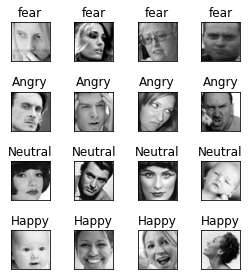

In [ ]:
fig = pyplot.figure(1, (4,4))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

# **Converting class vector to binary class matrix**

In [ ]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16496, 4)

# **Normalizing the data**

In [ ]:
img_arr = img_arr / 255

# **Splitting Data into test and train**

In [ ]:

# Splitting Data into test and train
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 48, 48, 3), (1650, 48, 48, 3), (14846, 4), (1650, 4))

In [ ]:

#Deleting the array of images
del img_arr
del img_label

# Defining width, height, depth, and number of classes
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:

#Defining transfer learning model
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

17227776/17225924 [==============================] - 1s 0us/step


# **Summary** 

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 24, 24, 32)        0     

# **Visualizing the model**

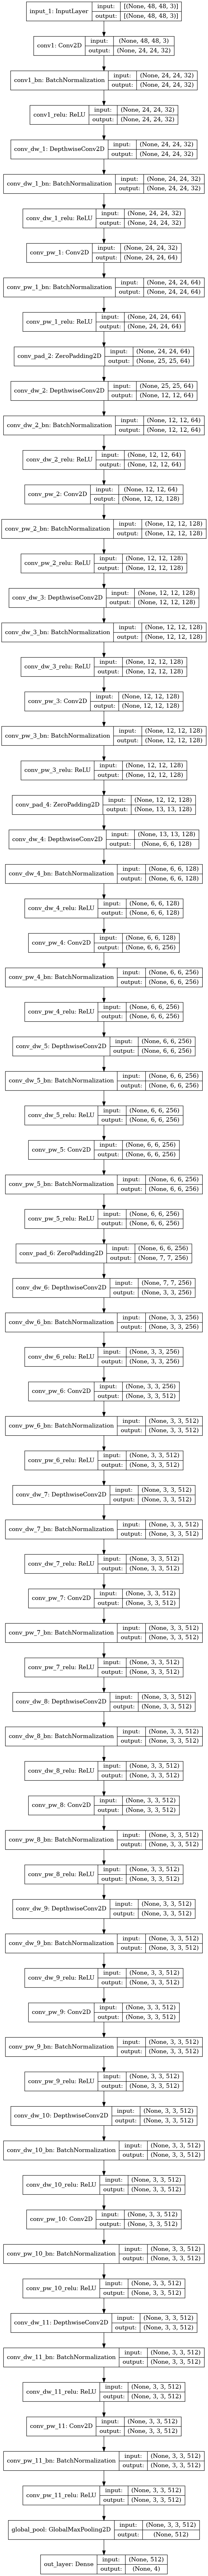

In [ ]:
from keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, expand_nested=True, to_file='model.png')

In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False

# **Data Agumentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

# **Early stopping` for avoiding overfitting of training data**

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler]

# **Model**

In [ ]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
593/593 [==============================] - 24s 27ms/step - loss: 1.7031 - accuracy: 0.4362 - val_loss: 2.1597 - val_accuracy: 0.3018
Epoch 2/40
593/593 [==============================] - 17s 28ms/step - loss: 1.0165 - accuracy: 0.5931 - val_loss: 1.1582 - val_accuracy: 0.5442
Epoch 3/40
593/593 [==============================] - 18s 29ms/step - loss: 0.9331 - accuracy: 0.6221 - val_loss: 0.8849 - val_accuracy: 0.6412
Epoch 4/40
593/593 [==============================] - 18s 29ms/step - loss: 0.8907 - accuracy: 0.6425 - val_loss: 0.9070 - val_accuracy: 0.6558
Epoch 5/40
593/593 [==============================] - 16s 26ms/step - loss: 0.8486 - accuracy: 0.6635 - val_loss: 0.8965 - val_accuracy: 0.6242
Epoch 6/40
593/593 [==============================] - 16s 27ms/step - loss: 0.8413 - accuracy: 0.6654 - val_loss: 0.8319 - val_accuracy: 0.6564
Epoch 7/40
593/593 [==============================] - 17s 29ms/step - loss: 0.8004 - accuracy: 0.6825 - val_loss: 0.8564 - val_accuracy:

# **Loss and Accuracy plots**

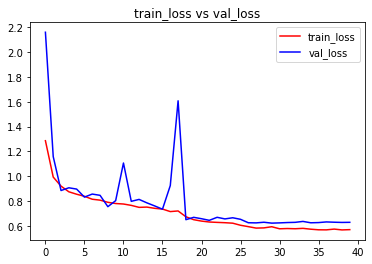

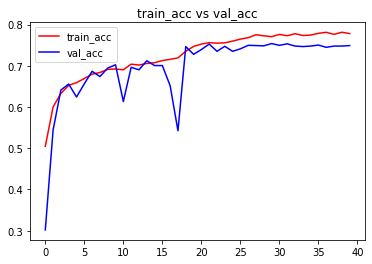

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
train_loss= history.history['loss']
val_loss= history.history['val_loss']
train_acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()
plt.savefig('model_epoch_history.png')

In [ ]:

# Fetching label to text 
label_to_text

{0: 'fear', 1: 'Angry', 2: 'Neutral', 3: 'Happy'}

In [ ]:
#Converting label_to_text to text_to_label
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'fear': 0, 'Angry': 1, 'Neutral': 2, 'Happy': 3}

# **Confusion Matrix**

test accuracy: 74.9091 %


              precision    recall  f1-score   support

           0       0.68      0.56      0.61       253
           1       0.64      0.62      0.63       283
           2       0.64      0.78      0.70       430
           3       0.91      0.85      0.88       684

    accuracy                           0.75      1650
   macro avg       0.72      0.70      0.71      1650
weighted avg       0.76      0.75      0.75      1650



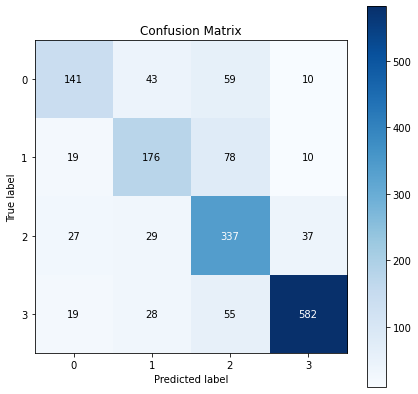

In [ ]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("model_confusion_matrix.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

from above plot the performance of happy face i.e 3 label is better performed than other emotions, main reason could be bacause of less data.

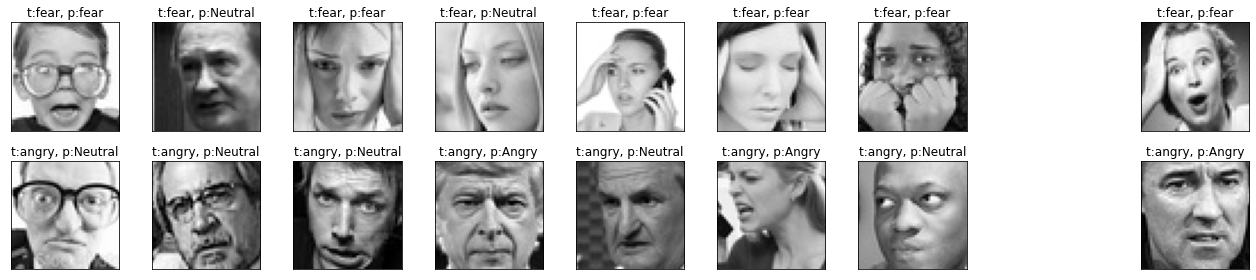

In [ ]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]
        
        
        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

# **Check for Mis-labeling**

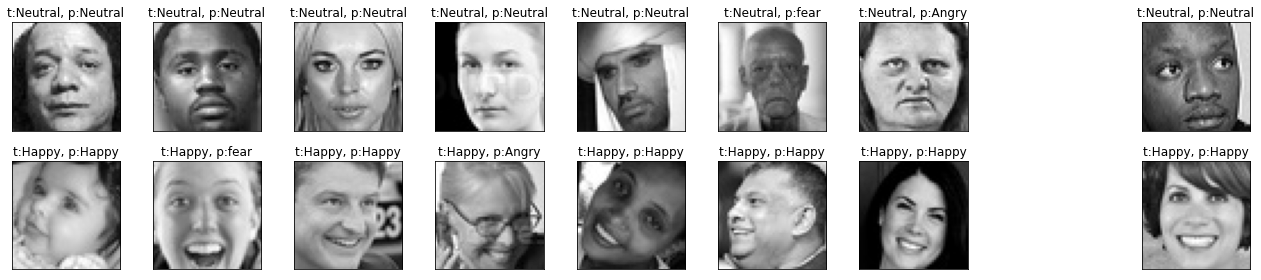

In [ ]:
np.random.seed(42)
neutral_imgs = np.random.choice(np.where(y_test[:, text_to_label["Neutral"]]==1)[0], size=9, replace=False)
happy_imgs = np.random.choice(np.where(y_test[:, text_to_label["Happy"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(neutral_imgs, happy_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:Neutral, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]
        
        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:Happy, p:{pred}")

        pyplot.tight_layout()

# **Summary**
* Initially I have imported data set from kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
* After loading data I have agumented the data and tried to plot the data
* Later splitted the data into train and test, implimentation of mobileNet transfer learning
* which was having a very good accuracy as showed in plots as well as confusion matrix
* confusion matrix also detecting happy faces are having good accuracy
* with the help of earlystopping callback we are to stop when the loss finction increase or reduce learning rate
* model had 75% validation accuracy with Early stopping
* The reason for low accuracy is the data quality. there are miss-classified images in the dataset. Many of them doesn't belong to their true class but are actually looking more likely to the predicted class
